# Outline of Code - Abby's and Vaishali's

Using the bootstrapping method of ensemble models
https://towardsdatascience.com/ensemble-models-5a62d4f4cb0c 

In [ ]:
#imports + pip install statements for multilingual BERT

In [ ]:
#imports + pip install statements for RoBERTa

In [ ]:
#mount Google Drive

In [ ]:
#read in csv file and split in half using train_test_split (each half will be further split when feeding into 
#each part of the ensemble model)

#Abby to read in NYC data here!

In [ ]:
#other preprocessing tasks if needed; if not, model set up will be done here for BERT

In [ ]:
#model setup for RoBERTa

In [ ]:
#read in models

In [ ]:
#model training + testing

In [ ]:
#confusion matrix for each model
#will determine final label based on highest softmax probability

# Model Setup - Abby's and Vaishali's

In [ ]:
!pip install -U keras==2.6.0 tensorflow-estimator==2.6.0 tf-models-official==2.6.0

In [ ]:
!pip install texthero -U

In [ ]:
#imports for twitter-roberta

#$ git clone https://github.com/dmis-lab/biobert.git - DO NOT NEED THIS FOR OUR PROJECT
#$ cd biobert; pip install -r requirements.txt
!pip install transformers
#!pip3 install torch torchvision
!pip install texthero -U
import texthero as hero
import pandas as pd

!pip install sentencepiece


In [ ]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.6.2
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#know that some keywords like 'disappointing' and 'horrible' did not
#yield as many reviews in initial phase; let's see if removing those words has an impact

df = pd.read_csv("/content/drive/MyDrive/DS440/Data for project/Stress Testing Data NY - Sheet1.csv") #REPLACE WITH NY DATA
df.head(5)
df.dropna(inplace = True)

#DATA PREPROCESSING USING TEXTHERO PACKAGE
df['clean_reviews'] = hero.clean(df['comments'])

df['clean_review_length'] = df['clean_reviews'].apply(lambda x: len(x))

#create list of words
#after running all the comments from predictions, saw many phrases that had the phrase 'aeur tm' in them
#hypothesis: error from texthero cleaning. Let's remove these and try again!
#NOTE: we'll need to change these words to accomodate for the new reviews
words_to_remove = ['(Website hidden by Airbnb)', '(Hidden by Airbnb)', 
                   'æ˜¯ä¸€ä¸ªéžå¸¸å‡ºè‰²çš„æˆ¿ä¸œ çœŸè¯š,ç»…å£«,å¹½é»˜ï½¡ä»–ä¼šå¸®åŠ©ä½ æè¡ŒæŽ,ç»™ä½ åšå¥½åƒçš„pancake,ä¹Ÿçƒ­å¿ƒåœ°æä¾›æ—…è¡Œå»ºè®®,å’Œä»–èŠå¤©éžå¸¸æœ‰è¶£ï½¡å…¬å¯“å°±å’Œç…§ç‰‡ä¸€æ¨¡ä¸€æ · å¤å¤ç¾Žå¼é£Ž æˆ‘éžå¸¸å–œæ¬¢~åœ°ç†ä½ç½®ä¹Ÿå¾ˆä¸é”™', 
                   'horrible']

#thank and thanks, treatment and treatments, 
def remove_words(text):
    #text = text.replace('thanks','thank')
    #text = text.replace('treatments','treatment')
    text = " ".join([word for word in text.split() if word not in words_to_remove])
    return text


df['clean_reviews'] = df['clean_reviews'].apply(lambda x: remove_words(x))

# Lemmatizer
import nltk
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
  text= [wn.lemmatize(word) for word in text.split()]
  text = ' '.join(text)
  return text

df['clean_lem'] = df['clean_reviews'].apply(lambda x: lemmatizer(x))

df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,comments,Label,clean_reviews,clean_review_length,clean_lem
0,- Bring earplugs! (Website hidden by Airbnb) T...,1,bring earplugs website hidden airbnb place nic...,412,bring earplug website hidden airbnb place nice...
1,*Note:* I have requested a partial refund for ...,1,note requested partial refund unclean inaccura...,1731,note requested partial refund unclean inaccura...
2,<br/>We had a great stay at Antonio's place. H...,0,br great stay antonio place helpful able flexi...,327,br great stay antonio place helpful able flexi...
3,"1. This is not an entire hosue, you get a priv...",1,entire hosue get private room people upper apa...,225,entire hosue get private room people upper apa...
4,A clean bedroom with adjacent bathroom facilit...,1,clean bedroom adjacent bathroom facilities not...,179,clean bedroom adjacent bathroom facility nothi...


In [ ]:
df.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



1    204
0    204
Name: Label, dtype: int64

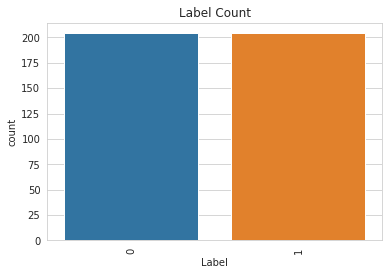

In [ ]:
#check for distribution of data - see that we have something very close to a 50-50 split between 1 and 0, which is good
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

sns.countplot(df['Label'])
plt.title('Label Count')
plt.xticks(rotation = 90)
df['Label'].value_counts()

In [ ]:
#create dataset from clean_reviews and Label columns
data = df['clean_reviews']
lab = df['Label']

df_main = pd.concat([data, lab], axis = 1)
df_main.head()

,clean_reviews,Label
0,bring earplugs website hidden airbnb place nic...,1
1,note requested partial refund unclean inaccura...,1
2,br great stay antonio place helpful able flexi...,0
3,entire hosue get private room people upper apa...,1
4,clean bedroom adjacent bathroom facilities not...,1


In [ ]:
#split into 50-50 for each model in ensemble
X = df_main['clean_reviews']
y = df_main['Label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 30)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



0    42
1    40
Name: Label, dtype: int64

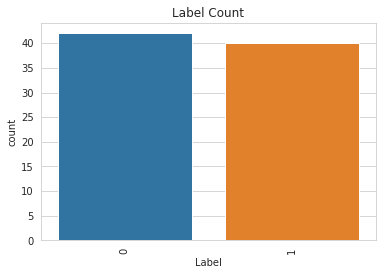

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

sns.countplot(y_test)
plt.title('Label Count')
plt.xticks(rotation = 90)
y_test.value_counts()

#note: random splitting of dataset results in 53-47 split for first portion of data and 47-52 split for second portion

In [ ]:
#merge both datasets again since we will be doing some more splitting in each model

#data1 = pd.concat([X1, y1], axis = 1)
#data2 = pd.concat([X2, y2], axis = 1)

# RoBERTa Model - Vaishali's

In [ ]:
import numpy as np
from sklearn import preprocessing

#!pip install biobert-embedding==0.1.2 torch==1.2.0 -f https://download.pytorch.org/whl/torch_stable.html
#from biobert_embedding.embedding import BiobertEmbedding
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# the model to train, base uncased BERT
#model_name = "google/bert_uncased_L-12_H-768_A-12"
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
#model_name = "allenai/scibert_scivocab_uncased"

# max sequence length for each input
length = 512 #BigBird lengths are typically 1024, 2048, or 4096; set to default length (4096)

In [ ]:
type(X_train)

pandas.core.series.Series

In [ ]:
#Load Tokenizer
#tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True, use_fast = True)

#Loading pretrained model and specify number of labels
#model = BertForSequenceClassification.from_pretrained(model_name, num_labels = 5)

#Tokenizer for twitter-roberta-base-sentiment
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True, use_fast = True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2, ignore_mismatched_sizes=True) #num_labels = 2 (1 and 0)

#SciBert
#tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

#model = AutoModelForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased")

# Our data should be a list
#body_text = list(data1['clean_reviews'])
#labels = list(data1['Label'])

# split into training & testing set
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(body_text, labels, test_size=0.3)

# Tokenizing X_train and X_test
#Look up stride(n_stride or docstride) - more context for overflowed text
X_train_tokenized = tokenizer(list(X_train),
                              padding=True,
                              truncation=True,
                              max_length=length)

X_test_tokenized = tokenizer(list(X_test),
                              padding=True,
                              truncation=True,
                              max_length=length)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch

#testing different keys
X_train_tokenized['attention_mask'][0][0:10]

X_train_tokenized['input_ids'][0][0:10]

#Transforming dataset into torch tensors
#self default class, 
class ReviewDataset(torch.utils.data.Dataset): 
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels
  
  def __len__(self):
    return len(self.encodings['input_ids'])

  def __getitem__(self, idx):
    item = {key:torch.tensor(val[idx]) for key,val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

#pass in encodings and pass in training labels
#converting x train and x test into torch tensors to load into model
train_dataset = ReviewDataset(X_train_tokenized, list(y_train))
test_dataset = ReviewDataset(X_test_tokenized, list(y_test))

In [ ]:
#set up training process - use TrainingArguments to 
# create a list of hyperparameters to use in the model
# Trainer will be used as the training function (same logic of model.fit())
from transformers import TrainingArguments
from transformers import Trainer

#training arguments
#batch size at 8 (matching Abby's observations), epoch between 2-6(most impact), learning rate 1e-4 to 1e-5
#output directory, evaluation at the end of each epoch, batch size, number of epochs,
args = TrainingArguments(
    output_dir="output",
    overwrite_output_dir =True,
    evaluation_strategy="epoch",
    eval_steps=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=6, #also try 2, 4, 5, 6
    save_steps=1,
    save_strategy="epoch",
    learning_rate=1e-4, #1e-5
    seed=0,
    )

#BEST PARAMETERS: 6 EPOCHS, 1E-4 LEARNING RATE

#Passing model, arguments, train and test data into trainer
trainer = Trainer(model=model,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset=test_dataset
                  )

#Train model
trainer.train() #changed batch sizes and trainer is running (seeing runtime of 10ish minutes each time)

# Model predictions
y_pred = trainer.predict(test_dataset)

print(y_pred)

***** Running training *****
  Num examples = 326
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 246


Epoch,Training Loss,Validation Loss
1,No log,0.674769
2,No log,0.321321
3,No log,0.633251
4,No log,0.306613
5,No log,0.475586
6,No log,0.451750


***** Running Evaluation *****
  Num examples = 82
  Batch size = 8
Saving model checkpoint to output/checkpoint-41
Configuration saved in output/checkpoint-41/config.json
Model weights saved in output/checkpoint-41/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 82
  Batch size = 8
Saving model checkpoint to output/checkpoint-82
Configuration saved in output/checkpoint-82/config.json
Model weights saved in output/checkpoint-82/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 82
  Batch size = 8
Saving model checkpoint to output/checkpoint-123
Configuration saved in output/checkpoint-123/config.json
Model weights saved in output/checkpoint-123/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 82
  Batch size = 8
Saving model checkpoint to output/checkpoint-164
Configuration saved in output/checkpoint-164/config.json
Model weights saved in output/checkpoint-164/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 82
  Batch

PredictionOutput(predictions=array([[ 3.5543475 , -3.54869   ],
       [ 3.5243564 , -3.5486758 ],
       [ 3.544927  , -3.5754497 ],
       [-3.7044024 ,  3.311632  ],
       [-3.5492885 ,  3.1717205 ],
       [-3.7200544 ,  3.311538  ],
       [ 3.542156  , -3.5231006 ],
       [-3.2693334 ,  2.9349315 ],
       [ 2.722154  , -2.6565545 ],
       [ 3.1090086 , -3.0777946 ],
       [ 0.5629256 , -0.5266451 ],
       [ 3.4529533 , -3.4976444 ],
       [-3.7040756 ,  3.3105412 ],
       [ 3.5459926 , -3.560192  ],
       [-3.731969  ,  3.2995193 ],
       [-2.7305386 ,  2.3948119 ],
       [ 3.5509083 , -3.567102  ],
       [-1.4316566 ,  1.1995867 ],
       [ 1.0239499 , -0.80363935],
       [-3.7052083 ,  3.305652  ],
       [-3.097084  ,  2.8468795 ],
       [ 3.5437362 , -3.5495694 ],
       [ 3.509623  , -3.5014124 ],
       [-3.7055964 ,  3.3089914 ],
       [ 3.5381842 , -3.5600603 ],
       [-3.7033007 ,  3.308602  ],
       [ 3.2971537 , -3.252548  ],
       [ 3.5158558 , -3.55

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        42
           1       0.93      0.93      0.93        40

    accuracy                           0.93        82
   macro avg       0.93      0.93      0.93        82
weighted avg       0.93      0.93      0.93        82

[[39  3]
 [ 3 37]]
[[39  3]
 [ 3 37]]


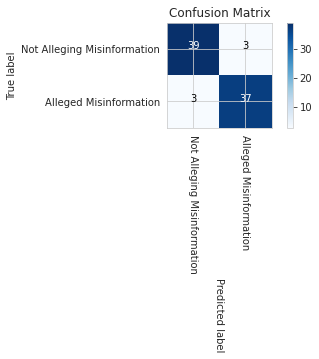

<Figure size 4320x4320 with 0 Axes>

In [ ]:
#print out the confusion matrix here!!
from sklearn.metrics import classification_report, confusion_matrix

#softmax probabilties
#argmax looks for the highest probability and returns index
y_pred_fix = np.argmax(y_pred[0], axis = 1)

#looking at first 5 values
y_pred_fix[0:5]

#Print classification report and confusion matrix 
print(classification_report(y_test,y_pred_fix))
print(confusion_matrix(y_test,y_pred_fix))

# Commented out IPython magic to ensure Python compatibility.
#plotting confusion matrix
# %matplotlib inline  
import itertools

cm = confusion_matrix(y_true=y_test, y_pred=y_pred_fix)

def plot_confusion_matrix(cm, classes, 
                          normalize=False, 
                          title='Confusion matrix', 
                          cmap=plt.cm.Blues):


  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=-90)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label', rotation=-90 )
    plt.figure(figsize= (60,60))

cm_plot_labels = ['Not Alleging Misinformation', 'Alleged Misinformation']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
y_pred_prob = softmax(y_pred[0], axis = 1)
print(y_pred_prob)

#save probabilities
roberta_pred = y_pred_prob

#clear GPU memory usage
model.cpu()

[[9.9917799e-01 8.2192628e-04]
 [9.9915302e-01 8.4694126e-04]
 [9.9919212e-01 8.0780906e-04]
 [8.9657237e-04 9.9910355e-01]
 [1.2038702e-03 9.9879628e-01]
 [8.8274386e-04 9.9911726e-01]
 [9.9914658e-01 8.5354643e-04]
 [2.0167185e-03 9.9798334e-01]
 [9.9540740e-01 4.5925896e-03]
 [9.9794793e-01 2.0521709e-03]
 [7.4830085e-01 2.5169909e-01]
 [9.9904275e-01 9.5714536e-04]
 [8.9784345e-04 9.9910229e-01]
 [9.9918061e-01 8.1934594e-04]
 [8.8283559e-04 9.9911726e-01]
 [5.9090094e-03 9.9409091e-01]
 [9.9919015e-01 8.0972147e-04]
 [6.7154534e-02 9.3284547e-01]
 [8.6147434e-01 1.3852571e-01]
 [9.0121949e-04 9.9909878e-01]
 [2.6147629e-03 9.9738508e-01]
 [9.9916995e-01 8.2995731e-04]
 [9.9909896e-01 9.0106140e-04]
 [8.9786906e-04 9.9910206e-01]
 [9.9917400e-01 8.2587218e-04]
 [9.0028107e-04 9.9909973e-01]
 [9.9857146e-01 1.4284985e-03]
 [9.9914825e-01 8.5176394e-04]
 [9.0081315e-04 9.9909925e-01]
 [8.9678873e-04 9.9910325e-01]
 [9.0369221e-04 9.9909633e-01]
 [9.0048928e-04 9.9909943e-01]
 [8.9890

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [ ]:
roberta_pred = pd.DataFrame(roberta_pred)
roberta_pred.to_csv('/content/drive/MyDrive/DS440/Data for project/roberta_prediction_probs.csv')

In [ ]:
##roberta_pred = pd.DataFrame(roberta_pred)

#from google.colab import files
#roberta_pred.to_csv('roberta_prediction_probs.csv')
#files.download('roberta_prediction_probs.csv')

# Multilinugal BERT Model - Abby's

In [ ]:
#df = data2

In [ ]:
#sample_size = int(len(df)) 
#sampleDf = df.sample(sample_size, random_state=23)
#x = sampleDf.clean_reviews.values
#y = sampleDf.Label.values
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)
encoded_Y_train

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,

In [ ]:
encoder_fname = 'airbnb_classes.npy'
my_wd = '/content/drive/My Drive/DS440/Data for project/'
np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

In [ ]:
 encoder = LabelEncoder()
 encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

In [ ]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would be much more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

reviews = tf.ragged.constant([
    encode_names(n) for n in X_train])

In [ ]:
print(X_train)

124    could tell apartment professionally run proper...
367    noisy whole night windows ' insulate street no...
53     cute place seems lot smaller photos overall fu...
337    place hostel hotel obvious check make sign som...
335    listing complicated one br br cottage located ...
                             ...                        
309    place look like pictures really run damp cold ...
386    loved host helpfulness location much lack clea...
140    stayed ivana three weeks early august apartmen...
301    location great probably best feature place iss...
293    house clean presentable main floor large nice ...
Name: clean_reviews, Length: 326, dtype: object


In [ ]:
tokenizedReview = tokenizer.tokenize(X_train[99])
for i in tokenizedReview:
  print(i, tokenizer.convert_tokens_to_ids([i]))

great [14772]
location [18214]
nic [46267]
##e [10112]
area [11168]
close [16065]
walk [33734]
sub [13987]
##way [14132]
restaurants [42460]
park [14900]
everything [42536]
expected [25973]
deb [55493]
##ora [14945]
##h [10237]
great [14772]
br [33989]


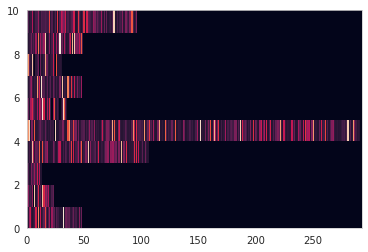

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*reviews.shape[0]
input_word_ids = tf.concat([cls, reviews], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

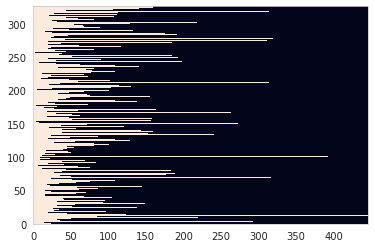

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

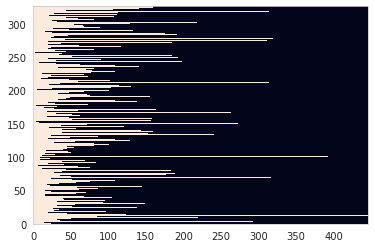

In [ ]:
type_cls = tf.zeros_like(cls)
type_review = tf.ones_like(reviews)
input_type_ids = tf.concat([type_cls, type_review], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [ ]:
max_seq_length = 512

In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))
 
  input = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return input

In [ ]:
X_train = bert_encode(X_train, tokenizer, max_seq_length)
X_test = bert_encode(X_test, tokenizer, max_seq_length)

In [ ]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

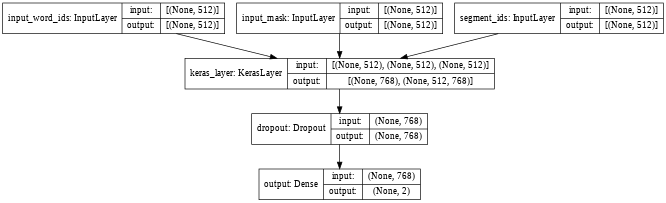

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
epochs = 5
batch_size = 5  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

#2e-5
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/5
66/66 [==============================] - 119s 1s/step - loss: 0.6165 - accuracy: 0.6779 - val_loss: 0.5065 - val_accuracy: 0.7927
Epoch 2/5
66/66 [==============================] - 95s 1s/step - loss: 0.4831 - accuracy: 0.8282 - val_loss: 0.6216 - val_accuracy: 0.8293
Epoch 3/5
66/66 [==============================] - 95s 1s/step - loss: 0.3247 - accuracy: 0.9233 - val_loss: 0.5945 - val_accuracy: 0.8537
Epoch 4/5
66/66 [==============================] - 95s 1s/step - loss: 0.1570 - accuracy: 0.9632 - val_loss: 0.5382 - val_accuracy: 0.8780
Epoch 5/5
66/66 [==============================] - 95s 1s/step - loss: 0.0936 - accuracy: 0.9785 - val_loss: 0.6151 - val_accuracy: 0.8659


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from scipy.special import softmax
y_pred = model.predict(X_test, verbose = False)
bert_pred = softmax(y_pred, axis = 1)
y_labels = np.argmax(y_pred,axis=1)

In [ ]:
i = 0
y_true = []
while i < len(dummy_y_test):
  y_true.append(int(dummy_y_test[i][1]))
  i += 1

In [ ]:
print(confusion_matrix(y_true, y_labels, labels = [0,1]))

[[34  8]
 [ 3 37]]


In [ ]:
print(classification_report(y_true, y_labels, labels = [0,1]))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86        42
           1       0.82      0.93      0.87        40

    accuracy                           0.87        82
   macro avg       0.87      0.87      0.87        82
weighted avg       0.87      0.87      0.87        82



In [ ]:
bert_pred

array([[0.73100364, 0.26899636],
       [0.73097533, 0.2690246 ],
       [0.73096925, 0.26903072],
       [0.2689862 , 0.7310137 ],
       [0.26942837, 0.73057157],
       [0.26902753, 0.73097235],
       [0.73101383, 0.26898617],
       [0.30603412, 0.69396585],
       [0.7302749 , 0.2697251 ],
       [0.27097395, 0.729026  ],
       [0.5534086 , 0.44659135],
       [0.7309958 , 0.2690042 ],
       [0.26896012, 0.7310398 ],
       [0.7308015 , 0.26919848],
       [0.26928246, 0.7307174 ],
       [0.6682865 , 0.3317136 ],
       [0.7310016 , 0.26899838],
       [0.26934817, 0.73065174],
       [0.7305839 , 0.26941594],
       [0.2689913 , 0.73100865],
       [0.26913625, 0.73086375],
       [0.7309861 , 0.26901394],
       [0.28358164, 0.7164184 ],
       [0.2690005 , 0.73099947],
       [0.7310103 , 0.26898974],
       [0.26895997, 0.73104006],
       [0.7308785 , 0.26912156],
       [0.7301331 , 0.26986694],
       [0.26897997, 0.73101985],
       [0.269005  , 0.73099494],
       [0.

In [ ]:
type(bert_pred)

numpy.ndarray

# Finalizing Predictions - Abby's and Vaishali's

We need to use a Max Voting strategy: "The final prediction in this technique is made based on majority voting for classification problems."



Confusion Matrix tells us:

If roberta predicts 0 and bert predict 1, then go with roberta. If roberta predicts 1 and bert predicts 0, then go with bert.

In [ ]:
#for loop for comparing probabilities

roberta_pred = pd.read_csv('/content/drive/MyDrive/DS440/Data for project/roberta_prediction_probs.csv') # [(p0, p1), (p0, p1)]
rob_pred = roberta_pred.to_numpy()
#bert_pred # [(p0, p1), (p0, p1)]
print(rob_pred)
print(bert_pred)
label = []

for (ro_p0, ro_p1), (b_p0, b_p1) in zip(rob_pred, bert_pred):
  roberta_label = np.argmax([ro_p0, ro_p1])
  bert_label = np.argmax([b_p0, b_p1])

  if roberta_label == bert_label:
    label.append(roberta_label)
  else:
    max_prob_index = np.argmax([ro_p0, ro_p1, b_p0, b_p1])
    label.append([0, 1, 0, 1][max_prob_index])

[[9.9917800e-01 8.2192630e-04]
 [9.9915300e-01 8.4694126e-04]
 [9.9919210e-01 8.0780906e-04]
 [8.9657237e-04 9.9910355e-01]
 [1.2038702e-03 9.9879630e-01]
 [8.8274386e-04 9.9911726e-01]
 [9.9914660e-01 8.5354643e-04]
 [2.0167185e-03 9.9798334e-01]
 [9.9540740e-01 4.5925896e-03]
 [9.9794793e-01 2.0521710e-03]
 [7.4830085e-01 2.5169910e-01]
 [9.9904275e-01 9.5714536e-04]
 [8.9784345e-04 9.9910230e-01]
 [9.9918060e-01 8.1934594e-04]
 [8.8283560e-04 9.9911726e-01]
 [5.9090094e-03 9.9409090e-01]
 [9.9919015e-01 8.0972150e-04]
 [6.7154534e-02 9.3284550e-01]
 [8.6147434e-01 1.3852571e-01]
 [9.0121950e-04 9.9909880e-01]
 [2.6147629e-03 9.9738510e-01]
 [9.9916995e-01 8.2995730e-04]
 [9.9909896e-01 9.0106140e-04]
 [8.9786906e-04 9.9910206e-01]
 [9.9917400e-01 8.2587220e-04]
 [9.0028107e-04 9.9909973e-01]
 [9.9857146e-01 1.4284985e-03]
 [9.9914825e-01 8.5176394e-04]
 [9.0081315e-04 9.9909925e-01]
 [8.9678870e-04 9.9910325e-01]
 [9.0369220e-04 9.9909633e-01]
 [9.0048930e-04 9.9909943e-01]
 [8.9890

In [ ]:
print(label)

[0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]


In [ ]:
print(classification_report(y_test, label, labels = [0,1]))

#roberta_label_temp = np.argmax(rob_pred, axis=1)
#print(classification_report(y_test, roberta_label_temp, labels = [0,1]))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        42
           1       0.93      0.93      0.93        40

    accuracy                           0.93        82
   macro avg       0.93      0.93      0.93        82
weighted avg       0.93      0.93      0.93        82



In [ ]:
print(confusion_matrix(y_test, label, labels = [0,1]))

[[39  3]
 [ 3 37]]
